#### Importing important libraries
- Natural Language Processing Libraries
- Preprocessing Libraries
- Machine Learning Models
- Machine Learning Evaluations

In [90]:
import nltk
import pandas as pd
import numpy as np
import re
import string
import math

from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import chi2

from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import f_oneway,ttest_ind,kruskal,mannwhitneyu

import matplotlib.pyplot as plt
import joblib
import itertools
import seaborn as sns

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Importing Dataset and Preprocessing

In [16]:
file_path = "toxicData/train.csv"
df = pd.read_csv(file_path)
df.head()

df["isToxic"] = df["toxic"]+df["severe_toxic"]
df["isToxic"] = df["isToxic"].apply(lambda x: 1 if x>=1 else -1)
df.drop(columns = ["id","toxic","severe_toxic","obscene","threat","insult","identity_hate"],inplace=True)
df.drop_duplicates(inplace=True)
df.head()

X_train, X_test, y_train, y_test = train_test_split(df["comment_text"],df["isToxic"],test_size=0.25,shuffle=True)

stop_words = set(stopwords.words('english'))
month_pattern = r"\b(January|February|March|April|May|June|July|August|September|October|November|December)\b"
link_pattern = r"http\S*"
punctuation_pattern = f"[{re.escape(string.punctuation)}]"

def preprocess_text(series):
    def clean_text(text):
        text = re.sub(r"\n|UTC|" + month_pattern + "|" + link_pattern, " ", text, flags=re.IGNORECASE)
        text = re.sub(punctuation_pattern, "", text)
        text = re.sub(r"[^a-zA-Z\s]", "", text) 
        text = text.lower()
        
        text = ' '.join([word for word in text.split() if word not in stop_words])
        return text.strip()
    return series.apply(clean_text)

X_train = preprocess_text(X_train)
X_train.head()

146999    dear bishonen werent forbidden pollute talk pa...
129132    yes ah sooobig dumb object bunch hosers give e...
59550     apologies wasnt sure everyone would know manit...
88137     find disrespectful gaming community community ...
21314     great famine forget google prove anything goog...
Name: comment_text, dtype: object

#### Applying Bag-of-Words (BOW) using sklearn vectorizer

In [17]:
vectorizer = CountVectorizer(binary=True)
X_train_counts = vectorizer.fit_transform(X_train)

chi2_scores, p_values = chi2(X_train_counts, y_train)
feature_scores = pd.DataFrame({
    'Feature': vectorizer.get_feature_names_out(),
    'Chi2 Score': chi2_scores,
    'P-Value': p_values
})
feature_scores = feature_scores.sort_values(by='Chi2 Score', ascending=False)
significantFeatures = feature_scores[feature_scores["P-Value"] <= 0.1]
significantFeatures.head(15)

,Feature,Chi2 Score,P-Value
58368,fuck,16613.550116,0.0
58408,fucking,10466.633255,0.0
138362,shit,7473.915570,0.0
10439,ass,5043.855819,0.0
17165,bitch,4550.501823,0.0
147533,suck,4212.712663,0.0
146747,stupid,3909.834630,0.0
10564,asshole,3466.619662,0.0
71643,idiot,2880.181659,0.0
52682,faggot,2853.385456,0.0


In [18]:
filteredFeatures = feature_scores[
    feature_scores['P-Value'] <= 0.1
].nlargest(1000, 'Chi2 Score')['Feature'].tolist()

filteredVectorizer = CountVectorizer(vocabulary=filteredFeatures,binary=True)
X_train = filteredVectorizer.transform(X_train)
X_test = filteredVectorizer.transform(X_test)

#### Initializing machine learning models, and establishing prediction and model weight handlers.

In [13]:
def pred_n_errors(model,x_vect,y_vect,weights):
    predictions = model.predict(x_vect)
    misclassified_indices = np.where(y_vect != predictions)[0]
    error_t = np.dot(weights, y_vect != predictions) / np.sum(weights)
    accuracy = accuracy_score(y_vect, predictions)

    epsilon = 1e-10
    if error_t < epsilon:
        alpha_t = float('inf')
    else:
        alpha_t = 0.5 * math.log((1 - error_t) / error_t)

    weights = weights * np.exp(-alpha_t * y_vect * predictions)
    weights /= np.sum(weights)

    return weights, misclassified_indices, accuracy
    
def ini_svmModel(X_train,y_train,weights):
    svmModel = SVC(kernel='linear')
    svmModel.fit(X_train, y_train, sample_weight=weights)
    
    updated_weights, misclassified_indices, accuracy = pred_n_errors(svmModel, X_train, y_train, weights)
    return svmModel, updated_weights, misclassified_indices, accuracy

def ini_decisionTrees(X_train,y_train,weights):
    dtModel = DecisionTreeClassifier(random_state=42)
    dtModel.fit(X_train, y_train, sample_weight=weights)

    updated_weights, misclassified_indices, accuracy = pred_n_errors(dtModel, X_train, y_train, weights)
    return dtModel, updated_weights, misclassified_indices, accuracy

def ini_logisticReg(X_train,y_train,weights):
    logisModel = LogisticRegression()
    logisModel.fit(X_train, y_train, sample_weight=weights)

    updated_weights, misclassified_indices, accuracy = pred_n_errors(logisModel, X_train, y_train, weights)
    return logisModel, updated_weights, misclassified_indices, accuracy

def saveModel(model,iteration):
    joblib.dump(model, f'ensamble_{iteration}.pkl')

def pred_test(model,X_test,y_test):
    predictions = model.predict(X_test)
    misclassified_indices = np.where(y_test != predictions)[0]
    accuracy = accuracy_score(y_test, predictions)

    return misclassified_indices, accuracy

In [12]:
orchestra = []
nTrain = X_train.shape[0]
model_functions = [ini_svmModel, ini_decisionTrees, ini_logisticReg]
all_permutations = list(itertools.permutations(model_functions))

for i,permu in enumerate(all_permutations):
    weights = np.ones(nTrain) / nTrain
    ensemble = []
    for j,ini in enumerate(permu):
        model, updated_weights, misclassified_indices, accuracy = ini(X_train, y_train, weights)
        weights = updated_weights
        instrument = {
            "model":model,
            "misclassified_indices":misclassified_indices,
            "accuracy":accuracy
        }
        ensemble.append(instrument)
        if j == 2:
            saveModel(model,i+1)
    orchestra.append(ensemble)


In [20]:
testPreds = []
for ensemble in orchestra:
    misclassified_indices, accuracy = pred_test(ensemble[2]["model"],X_test,y_test)
    instrument = {
            "model":ensemble[2]["model"],
            "misclassified_indices":misclassified_indices,
            "accuracy":accuracy
        }
    testPreds.append(instrument)

In [83]:
modelSequences = ["svm-dt-logiReg","svm-logiReg-dt","dt-svm-logiReg","dt-logiReg-svm","logiReg-svm-dt","logiReg-dt-svm"]
firstIteration = list(map(lambda x: x[0]["accuracy"],orchestra))
secondIteration = list(map(lambda x: x[1]["accuracy"],orchestra))
thirdIteration = list(map(lambda x: x[2]["accuracy"],orchestra))
finalPrediction = list(map(lambda x: x["accuracy"],testPreds))

modelSequenceAccuracy = {
    "modelSequences": modelSequences,
    "firstIteration": firstIteration,
    "secondIteration": secondIteration,
    "thirdIteration": thirdIteration,
    "finalPrediction": finalPrediction
}
modelSequenceAccuracy = pd.DataFrame(modelSequenceAccuracy)

In [24]:
modelSequenceAccuracy.head(6)

,modelSequences,firstIteration,secondIteration,thirdIteration,finalPrediction
0,svm-dt-logiReg,0.904744,0.987642,0.095256,0.095606
1,svm-logiReg-dt,0.904744,0.619813,0.992329,0.467701
2,dt-svm-logiReg,0.993466,0.904744,0.600160,0.201690
3,dt-logiReg-svm,0.993466,0.669171,0.904744,0.904394
4,logiReg-svm-dt,0.904744,0.109402,0.987642,0.519690
5,logiReg-dt-svm,0.904744,0.987642,0.095256,0.095606


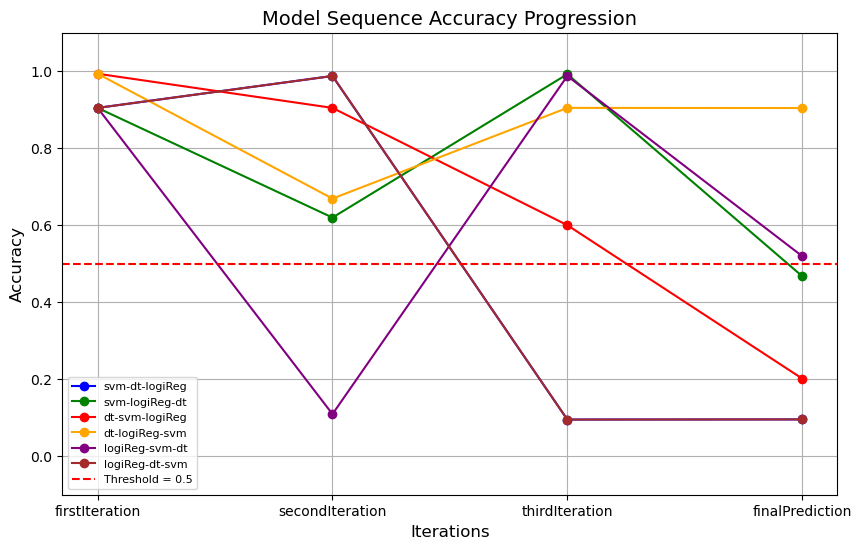

In [87]:
plt.figure(figsize=(10, 6))

iterations = ["firstIteration", "secondIteration", "thirdIteration", "finalPrediction"]


colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown']

for i, row in modelSequenceAccuracy.iterrows():
    plt.plot(iterations, row[1:5], marker='o', label=row["modelSequences"], color=colors[i]) 

plt.axhline(y=0.5, color='r', linestyle='--', label="Threshold = 0.5")

plt.title("Model Sequence Accuracy Progression", fontsize=14)
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(-0.1, 1.1)
plt.grid(True)
plt.legend(loc='lower left', fontsize=8)
plt.show()

#### Finding significant differences between iterations

In [40]:
# If the test set is involved
kruskal_stat, kruskal_p_value = kruskal(modelSequenceAccuracy["firstIteration"], modelSequenceAccuracy["secondIteration"], modelSequenceAccuracy["thirdIteration"],modelSequenceAccuracy["finalPrediction"])

print(f"Kruskal-Wallis Test statistic: {kruskal_stat}")
print(f"P-value: {kruskal_p_value}")

if kruskal_p_value < 0.05:
    print("There is a significant difference between iterations.")
else:
    print("No significant difference between iterations.")

Kruskal-Wallis Test statistic: 8.330454679657523
P-value: 0.03965378604378676
There is a significant difference between iterations.


In [41]:
# If the test set is NOT involved
kruskal_stat, kruskal_p_value = kruskal(modelSequenceAccuracy["firstIteration"], modelSequenceAccuracy["secondIteration"], modelSequenceAccuracy["thirdIteration"])

print(f"Kruskal-Wallis Test statistic: {kruskal_stat}")
print(f"P-value: {kruskal_p_value}")

if kruskal_p_value < 0.05:
    print("There is a significant difference between iterations.")
else:
    print("No significant difference between iterations.")

Kruskal-Wallis Test statistic: 2.421156609195397
P-value: 0.29802488042654457
No significant difference between iterations.


In [45]:
u_stat_first_second, p_value_first_second = mannwhitneyu(modelSequenceAccuracy["firstIteration"], modelSequenceAccuracy["secondIteration"])
print(f"First vs Second: U-statistic = {u_stat_first_second}, P-value = {p_value_first_second}")

u_stat_second_third, p_value_second_third = mannwhitneyu(modelSequenceAccuracy["secondIteration"], modelSequenceAccuracy["thirdIteration"])
print(f"Second vs Third: U-statistic = {u_stat_second_third}, P-value = {p_value_second_third}")

u_stat_first_third, p_value_first_third = mannwhitneyu(modelSequenceAccuracy["firstIteration"], modelSequenceAccuracy["thirdIteration"])
print(f"First vs Third: U-statistic = {u_stat_first_third}, P-value = {p_value_first_third}")

First vs Second: U-statistic = 26.0, P-value = 0.2112995473337107
Second vs Third: U-statistic = 20.5, P-value = 0.7461883116489224
First vs Third: U-statistic = 26.0, P-value = 0.2112995473337107


In [123]:
effect_size_first_second = abs(u_stat_first_second) / (len(modelSequenceAccuracy["firstIteration"]) * len(modelSequenceAccuracy["secondIteration"]))
print(f"Effect Size (First vs Second): {effect_size_first_second}")

effect_size_second_third = abs(u_stat_second_third) / (len(modelSequenceAccuracy["secondIteration"]) * len(modelSequenceAccuracy["thirdIteration"]))
print(f"Effect Size (Second vs Third): {effect_size_second_third}")

effect_size_first_third = abs(u_stat_first_third) / (len(modelSequenceAccuracy["firstIteration"]) * len(modelSequenceAccuracy["thirdIteration"]))
print(f"Effect Size (First vs Third): {effect_size_first_third}")

Effect Size (First vs Second): 0.7222222222222222
Effect Size (Second vs Third): 0.5694444444444444
Effect Size (First vs Third): 0.7222222222222222


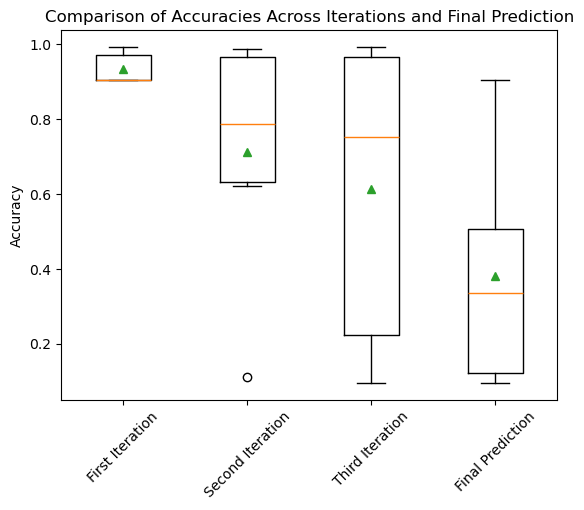

In [51]:
all_accuracies = [modelSequenceAccuracy["firstIteration"], modelSequenceAccuracy["secondIteration"], modelSequenceAccuracy["thirdIteration"],modelSequenceAccuracy["finalPrediction"]]

plt.boxplot(all_accuracies, labels=['First Iteration', 'Second Iteration', 'Third Iteration', 'Final Prediction'],showmeans=True)
plt.title('Comparison of Accuracies Across Iterations and Final Prediction')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

#### Testing each model's reliability

In [54]:
iterations = ['firstIteration', 'secondIteration', 'thirdIteration']
modelSequenceAccuracy['std_deviation'] = modelSequenceAccuracy[iterations].std(axis=1)
modelSequenceAccuracy['mean'] = modelSequenceAccuracy[iterations].mean(axis=1)
modelSequenceAccuracy['coefficient_of_variation'] = (modelSequenceAccuracy['std_deviation']/modelSequenceAccuracy['mean'])*100
modelSequenceAccuracy.head(6)

,modelSequences,firstIteration,secondIteration,thirdIteration,finalPrediction,std_deviation,mean,coefficient_of_variation
0,svm-dt-logiReg,0.904744,0.987642,0.095256,0.095606,0.493034,0.662547,74.414970
1,svm-logiReg-dt,0.904744,0.619813,0.992329,0.467701,0.194776,0.838962,23.216256
2,dt-svm-logiReg,0.993466,0.904744,0.600160,0.201690,0.206289,0.832790,24.770877
3,dt-logiReg-svm,0.993466,0.669171,0.904744,0.904394,0.167598,0.855794,19.583889
4,logiReg-svm-dt,0.904744,0.109402,0.987642,0.519690,0.484896,0.667263,72.669488
5,logiReg-dt-svm,0.904744,0.987642,0.095256,0.095606,0.493034,0.662547,74.414970


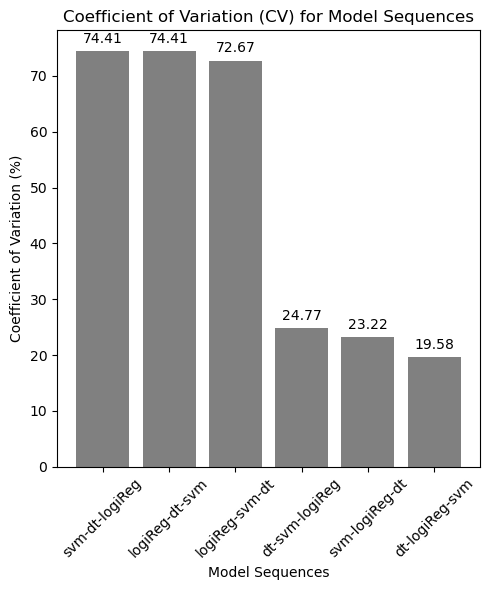

In [70]:
modelSequenceAccuracy_sorted = modelSequenceAccuracy.sort_values(by='coefficient_of_variation', ascending=False)

plt.figure(figsize=(5, 6))
bars = plt.bar(modelSequenceAccuracy_sorted['modelSequences'], modelSequenceAccuracy_sorted['coefficient_of_variation'], color='gray')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45)
plt.title('Coefficient of Variation (CV) for Model Sequences')
plt.xlabel('Model Sequences')
plt.ylabel('Coefficient of Variation (%)')
plt.tight_layout()

plt.show()

#### Determine the correlation matrix between iterations and final prediction

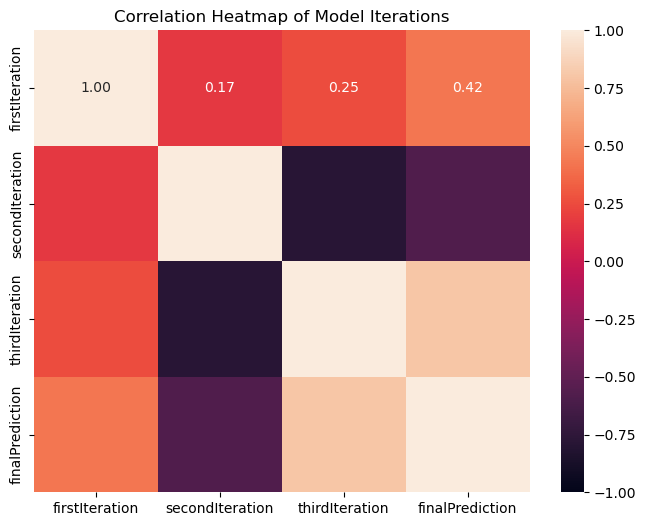

In [80]:
columns_to_exclude = ['modelSequences',"mean", "std_deviation", "coefficient_of_variation"]
correlation_matrix = modelSequenceAccuracy.drop(columns=columns_to_exclude).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="rocket", fmt=".2f", vmin=-1, vmax=1, cbar=True)

plt.title("Correlation Heatmap of Model Iterations")
plt.show()

In [81]:
correlation_matrix

,firstIteration,secondIteration,thirdIteration,finalPrediction
firstIteration,1.000000,0.170630,0.254602,0.423758
secondIteration,0.170630,1.000000,-0.786127,-0.579207
thirdIteration,0.254602,-0.786127,1.000000,0.798997
finalPrediction,0.423758,-0.579207,0.798997,1.000000


#### Creating a confusion matrix (train dataset)

In [89]:
for ensemble in orchestra:
    for model_info in ensemble:
        y_pred = y_train.copy()
        y_pred = [(-1 if y_train.iloc[i] == 1 else 1) if i in model_info["misclassified_indices"] else y_train.iloc[i] for i in range(len(y_train))]
        
        model_info["predictions"] = y_pred

In [92]:
for ensemble in orchestra:
    for model_info in ensemble:
        y_pred = model_info["predictions"]
        cm = confusion_matrix(y_train, y_pred)
        model_info[f"confusion_matrix"] = cm

In [99]:
modelSequences = ["svm_1","dt_1","logiReg_1","svm_2","logiReg_2","dt_2","dt_3","svm_3","logiReg_3","dt_4","logiReg_4","svm_4","logiReg_5","svm_5","dt_5","logiReg_6","dt_6","svm_6"]
trueNegatives = list(map(lambda model: model["confusion_matrix"][0][0], 
                          [m for ensemble in orchestra for m in ensemble]))
falsePositives = list(map(lambda model: model["confusion_matrix"][0][1], 
                          [m for ensemble in orchestra for m in ensemble]))
falseNegatives = list(map(lambda model: model["confusion_matrix"][1][0], 
                          [m for ensemble in orchestra for m in ensemble]))
truePositives = list(map(lambda model: model["confusion_matrix"][1][1], 
                          [m for ensemble in orchestra for m in ensemble]))

confusions = {
    "modelSequences": modelSequences,
    "trueNegatives" : trueNegatives,
    "falsePositives" : falsePositives,
    "falseNegatives" : falseNegatives,
    "truePositives" : truePositives,
}

confusions = pd.DataFrame(confusions)

In [100]:
confusions

,modelSequences,trueNegatives,falsePositives,falseNegatives,truePositives
0,svm_1,97922,10276,1124,10356
1,dt_1,106860,1338,141,11339
2,logiReg_1,10276,97922,10356,1124
3,svm_2,97922,10276,1124,10356
4,logiReg_2,67025,41173,4327,7153
5,dt_2,107369,829,89,11391
6,dt_3,107492,706,76,11404
7,svm_3,97922,10276,1124,10356
8,logiReg_3,64935,43263,4589,6891
9,dt_4,107492,706,76,11404


In [119]:
confusions['accuracy'] = (confusions['trueNegatives'] + confusions['truePositives']) / (
    confusions['trueNegatives'] + confusions['falsePositives'] + confusions['falseNegatives'] + confusions['truePositives'])
confusions['precision'] = confusions['truePositives'] / (confusions['truePositives'] + confusions['falsePositives'])
confusions['recall'] = confusions['truePositives'] / (confusions['truePositives'] + confusions['falseNegatives'])
confusions['f1_score'] = 2 * (confusions['precision'] * confusions['recall']) / (confusions['precision'] + confusions['recall'])


metrics = confusions[['modelSequences', 'accuracy', 'precision', 'recall', 'f1_score']]

In [120]:
metrics = metrics.style.apply(
    lambda x: ['background-color: yellow' if x.name in [2, 5, 8, 11, 14, 17] else '' for i in range(len(x))], axis=1
)

In [121]:
metrics

,modelSequences,accuracy,precision,recall,f1_score
0,svm_1,0.904744,0.501939,0.902091,0.644993
1,dt_1,0.987642,0.894455,0.987718,0.938776
2,logiReg_1,0.095256,0.011348,0.097909,0.020339
3,svm_2,0.904744,0.501939,0.902091,0.644993
4,logiReg_2,0.619813,0.148016,0.623084,0.239207
5,dt_2,0.992329,0.932160,0.992247,0.961266
6,dt_3,0.993466,0.941701,0.993380,0.966850
7,svm_3,0.904744,0.501939,0.902091,0.644993
8,logiReg_3,0.600160,0.137397,0.600261,0.223610
9,dt_4,0.993466,0.941701,0.993380,0.966850


#### Creating a confusion matrix (test dataset-final models)

In [126]:
for model_info in testPreds:
    y_pred = y_test.copy()
    y_pred = [(-1 if y_test.iloc[i] == 1 else 1) if i in model_info["misclassified_indices"] else y_test.iloc[i] for i in range(len(y_test))]
        
    model_info["predictions"] = y_pred
    cm = confusion_matrix(y_test, y_pred)
    model_info[f"confusion_matrix"] = cm
    
modelSequences = ["svm-dt-logiReg","svm-logiReg-dt","dt-svm-logiReg","dt-logiReg-svm","logiReg-svm-dt","logiReg-dt-svm"]
trueNegatives = list(map(lambda model: model["confusion_matrix"][0][0], testPreds))
falsePositives = list(map(lambda model: model["confusion_matrix"][0][1], testPreds))
falseNegatives = list(map(lambda model: model["confusion_matrix"][1][0], testPreds))
truePositives = list(map(lambda model: model["confusion_matrix"][1][1], testPreds))

confusions_finalModel = {
    "modelSequences": modelSequences,
    "trueNegatives" : trueNegatives,
    "falsePositives" : falsePositives,
    "falseNegatives" : falseNegatives,
    "truePositives" : truePositives,
}

confusions_finalModel = pd.DataFrame(confusions_finalModel)

In [127]:
confusions_finalModel

,modelSequences,trueNegatives,falsePositives,falseNegatives,truePositives
0,svm-dt-logiReg,0,36079,0,3814
1,svm-logiReg-dt,15938,20141,1094,2720
2,dt-svm-logiReg,4394,31685,162,3652
3,dt-logiReg-svm,36079,0,3814,0
4,logiReg-svm-dt,18001,18078,1083,2731
5,logiReg-dt-svm,0,36079,0,3814


In [128]:
confusions_finalModel['accuracy'] = (confusions_finalModel['trueNegatives'] + confusions_finalModel['truePositives']) / (
    confusions_finalModel['trueNegatives'] + confusions_finalModel['falsePositives'] + confusions_finalModel['falseNegatives'] + confusions_finalModel['truePositives'])
confusions_finalModel['precision'] = confusions_finalModel['truePositives'] / (confusions_finalModel['truePositives'] + confusions_finalModel['falsePositives'])
confusions_finalModel['recall'] = confusions_finalModel['truePositives'] / (confusions_finalModel['truePositives'] + confusions_finalModel['falseNegatives'])
confusions_finalModel['f1_score'] = 2 * (confusions_finalModel['precision'] * confusions_finalModel['recall']) / (confusions_finalModel['precision'] + confusions_finalModel['recall'])


metrics = confusions_finalModel[['modelSequences', 'accuracy', 'precision', 'recall', 'f1_score']]
metrics

,modelSequences,accuracy,precision,recall,f1_score
0,svm-dt-logiReg,0.095606,0.095606,1.000000,0.174526
1,svm-logiReg-dt,0.467701,0.118980,0.713162,0.203936
2,dt-svm-logiReg,0.201690,0.103348,0.957525,0.186560
3,dt-logiReg-svm,0.904394,NaN,0.000000,NaN
4,logiReg-svm-dt,0.519690,0.131241,0.716046,0.221825
5,logiReg-dt-svm,0.095606,0.095606,1.000000,0.174526
